In [1]:
from data_loader import data_loader, preprocess
from model_helper import get_tuned_gamma, train, tune_lambda, plot_lambda_tuning
import numpy as np
from PCA import project_and_plot_PCA, corr_plot, plot_reconstruction_loss
import pandas as pd
from Bootstrap_and_eval import eval
from NN import train_and_evaluate_nn


In [2]:
df = data_loader(num=1000)

# filter columns to only include columns in the features list below
features = ['loan_amount_000s', 'loan_type', 'owner_occupancy', 
       'property_type','applicant_income_000s', 'purchaser_type', 'hud_median_family_income',
       'tract_to_msamd_income', 'number_of_owner_occupied_units', 
       'number_of_1_to_4_family_units', 'race_ethnicity', 'state_code', 'county_code',
       'joint_sex',"minority_population", 'lien_status']

x_train, x_test, y_train, y_test, train_groups, test_groups = preprocess(df, features)

Loading data...
processed_data.csv exists. Loading data from file.
Sample size BEFORE filtering 641
Sample size AFTER filtering 468
Num features BEFORE filtering 468
Num features AFTER filtering 468
x_train shape:  (374, 16)
y_train shape:  (94, 16)


In [ ]:
betas = np.random.rand(x_train.shape[1])
gammas = np.linspace(0.1, 1, 10)
best_gamma = get_tuned_gamma(gammas, x_train, y_train, num_folds=5, verbose=False)

In [ ]:
betas = np.random.rand(x_train.shape[1])
_lambda = None 
fair_loss_ = 'NO l2'

unfair_preds = train(x_train, y_train, x_test, y_test, train_groups, fair_loss_, best_gamma, lambda_val=1)  # do use l2 regularization here ergo False


With L2

In [ ]:
betas = np.random.rand(x_train.shape[1])
_lambda = None 
fair_loss_ = False

unfair_preds = train(x_train, y_train, x_test, y_test, train_groups, best_gamma, fair_loss_) 

First tune hyperparameter lambda 

then train L2 + Fairness loss

In [ ]:
fair_loss_ = True
performance_metrics = tune_lambda(x_train, y_train, test_groups, train_groups, x_test, y_test, fair_loss_, best_gamma)

In [ ]:
lambda_vals = [0.001, 0.005, 0.01, 0.05, 0.1, 1]
plot_lambda_tuning(performance_metrics, lambda_vals)


In [ ]:
betas = np.random.rand(x_train.shape[1])
_lambda = None 
fair_loss_ = True

unfair_preds = train(x_train, y_train, x_test, y_test, train_groups, fair_loss_, best_gamma) 

In [3]:
# print shape of x_train, y_train, x_test, y_test, groups,
print("x_train shape: ", x_train.shape, type(x_train))
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print("train groups shape: ", train_groups.shape)
print("test groups shape: ", test_groups.shape)


x_train shape:  (374, 16) <class 'numpy.ndarray'>
y_train shape:  (374,)
x_test shape:  (94, 16)
y_test shape:  (94,)
train groups shape:  (374, 2)
test groups shape:  (94, 2)


Fit PCA components to data

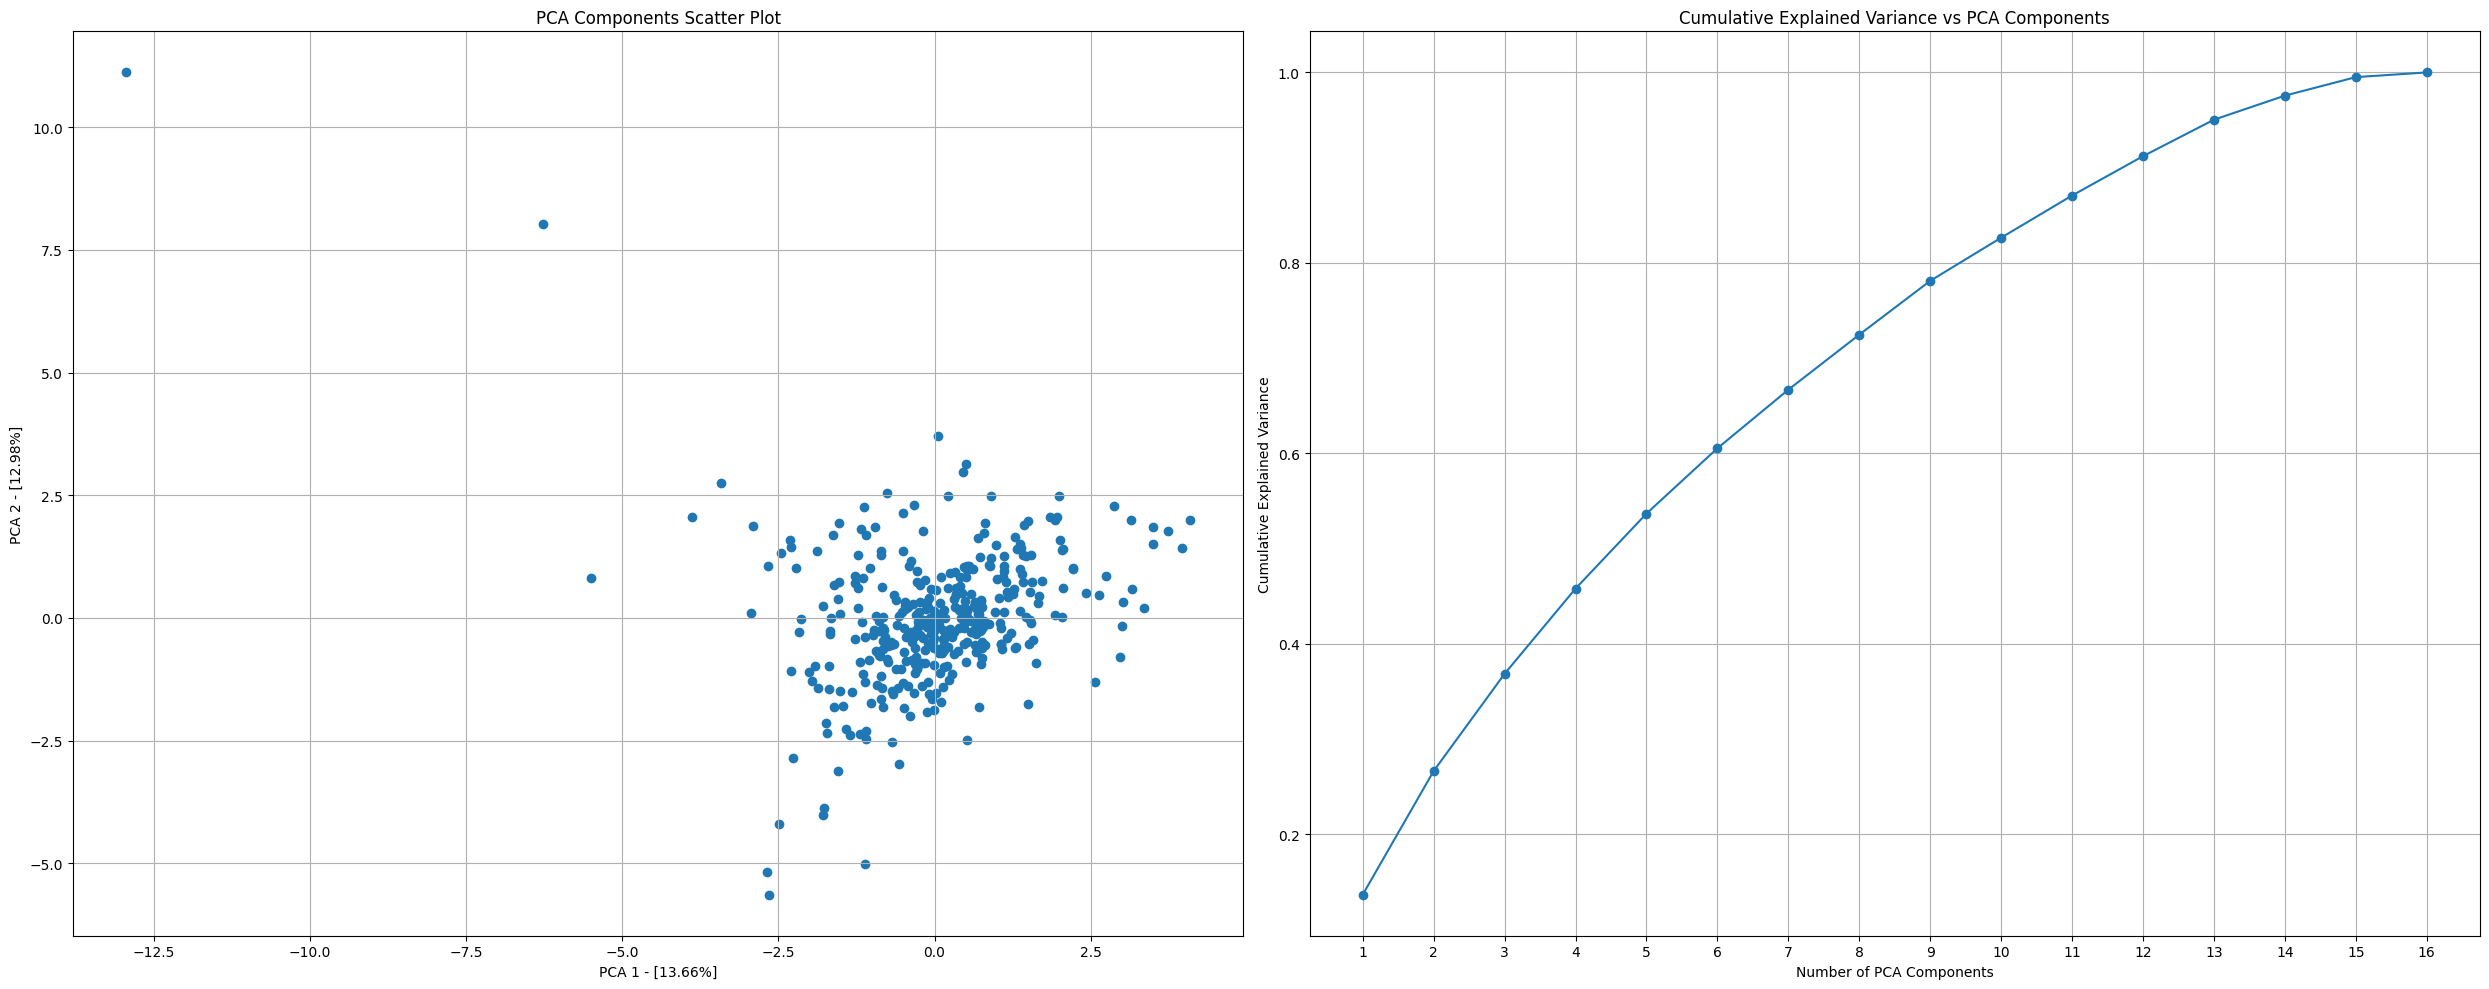

In [4]:
x_train_pd = pd.DataFrame(x_train, columns=features)
x_test_pd = pd.DataFrame(x_test, columns=features)
project_and_plot_PCA(x_train_pd, n_components=len(features), size = (25,10),corr_metric='pearson')

In [ ]:
corr_plot(x_train_pd, 'pearson', train_groups, n_components=len(features), fair=False)
corr_plot(x_train_pd, 'pearson', train_groups, n_components=len(features), fair=True)

In [ ]:
plot_reconstruction_loss(x_train_pd, x_test_pd, len(features), train_groups, fair=False)

Train model on fair PCA data 

In [5]:
eval(x_train_pd, x_test_pd, y_test, y_train, y_test, train_groups)

X_test.shape, y_test.shape, binary_predictions.shape=((94, 16), (94,), (94,))
Logistic regression accuracy: 60.64%
              precision    recall  f1-score   support

           0       0.30      0.65      0.41        20
           1       0.86      0.59      0.70        74

    accuracy                           0.61        94
   macro avg       0.58      0.62      0.56        94
weighted avg       0.74      0.61      0.64        94

X_test.shape, y_test.shape, binary_predictions.shape=((94, 16), (94,), (94,))
Logistic regression accuracy: 68.09%
              precision    recall  f1-score   support

           0       0.39      0.85      0.53        20
           1       0.94      0.64      0.76        74

    accuracy                           0.68        94
   macro avg       0.66      0.74      0.64        94
weighted avg       0.82      0.68      0.71        94

X_test_scaled_fair_PCA.shape, y_test_enc.shape=((94, 14), (94,))
X_test.shape, y_test.shape, binary_predictions.shap

(array([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1]),
 array([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1]),
 array([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1]))

BLACK BOX MODEL

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000, alpha=0.0001)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.65      0.75      0.70        20
           1       0.93      0.89      0.91        74

    accuracy                           0.86        94
   macro avg       0.79      0.82      0.80        94
weighted avg       0.87      0.86      0.87        94

